## Visualización de Filtros y Activaciones en Redes Neuronales Convolucionales (CNNs)

Este cuaderno tiene como objetivo principal desmitificar las **Redes Neuronales Convolucionales (CNNs)**, mostrando cómo sus capas internas "ven" y "procesan" las imágenes. A menudo, las CNNs pueden parecer "cajas negras", pero al visualizar sus **filtros (kernels)** y las **activaciones (mapas de características)**, podemos obtener una comprensión intuitiva de cómo aprenden a detectar patrones.

En este laboratorio, construiremos y entrenaremos una CNN simple en el dataset MNIST (dígitos escritos a mano) y luego exploraremos:
1.  **Los filtros aprendidos** en las capas convolucionales.
2.  **Los mapas de características (activaciones)** que se generan a medida que una imagen pasa por la red.

### 1. Configuración Inicial y Carga de Datos

Comenzaremos importando las librerías necesarias y cargando el popular dataset MNIST. MNIST consta de 60,000 imágenes de entrenamiento y 10,000 imágenes de prueba de dígitos escritos a mano (0-9).

In [1]:
# Importamos TensorFlow, la API de Keras (layers y models) y Matplotlib.
import tensorflow as tf
from tensorflow.keras import layers, models # 'layers' para definir capas, 'models' para Sequential y Model
import matplotlib.pyplot as plt # Para todas las visualizaciones
import numpy as np # Para operaciones con arrays numéricos

2025-06-16 22:49:19.825437: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-16 22:49:19.836757: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-16 22:49:19.940110: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-16 22:49:19.940248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-16 22:49:19.942335: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# Cargamos el dataset MNIST directamente desde Keras.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocesamiento de las imágenes:
# 1. Expandimos las dimensiones: MNIST tiene imágenes de 28x28. Las CNNs esperan (alto, ancho, canales).
#    Para imágenes en escala de grises, el canal es 1. Usamos 'None' para añadir esta dimensión.
x_train = x_train[..., None] / 255.0 # Añade un eje al final y normaliza a [0, 1]
x_test  = x_test[..., None]  / 255.0  # Misma operación para el conjunto de prueba

11490434/11490434 [==============================] - 0s 0us/step


### 1.1. Visualizar una Muestra de Datos

Es útil ver cómo lucen las imágenes después del preprocesamiento, antes de pasarlas a la red.

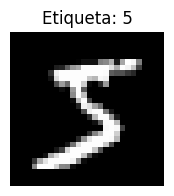

In [3]:
# Mostramos una imagen de ejemplo del conjunto de entrenamiento.
plt.figure(figsize=(2, 2))
plt.imshow(x_train[0, :, :, 0], cmap='gray') # Muestra la primera imagen (28x28, 1 canal).
plt.title(f"Etiqueta: {y_train[0]}")
plt.axis('off') # Oculta los ejes para una visualización limpia.
plt.show()

### 2. Construcción y Entrenamiento de una CNN Simple

Construiremos una CNN sencilla con pocas capas para facilitar la visualización. Los componentes clave son:

-   **`Conv2D` (Capa Convolucional):** Aplica un conjunto de filtros pequeños a la imagen de entrada, detectando características como bordes, texturas o patrones simples. Cada filtro genera un "mapa de características" o "mapa de activación".
-   **`MaxPooling2D` (Capa de Agrupación Máxima):** Reduce la dimensionalidad de los mapas de características, tomando el valor máximo dentro de pequeñas ventanas. Esto ayuda a hacer la red más robusta a pequeñas traslaciones y a reducir el número de parámetros.
-   **`ReLU` (Rectified Linear Unit):** Una función de activación no lineal que introduce no linealidad en el modelo, permitiéndole aprender patrones más complejos. Simplemente convierte todos los valores negativos en cero.
-   **`Flatten`:** Convierte los mapas de características 2D/3D en un vector 1D, preparando los datos para las capas densas (fully connected).
-   **`Dense` (Capa Densa/Completamente Conectada):** Capas neuronales tradicionales donde cada neurona está conectada a todas las neuronas de la capa anterior. Realizan la clasificación final.
-   **`Softmax`:** Función de activación en la capa de salida para problemas de clasificación multiclase. Convierte los logits (salidas en bruto) en probabilidades que suman 1.

In [4]:
# Definimos el modelo Sequential de Keras.
model = models.Sequential([
    # Primera capa convolucional:
    # 16 filtros de tamaño 3x3.
    # 'activation='relu'' aplica la función de activación ReLU.
    # 'input_shape=(28,28,1)' especifica la forma de la entrada (28x28 píxeles, 1 canal para escala de grises).
    layers.Conv2D(16, 3, activation='relu', input_shape=(28,28,1)),

    # Capa de agrupación máxima: reduce la dimensionalidad espacial (por defecto, 2x2).
    layers.MaxPooling2D(),

    # Segunda capa convolucional: 32 filtros de tamaño 3x3.
    layers.Conv2D(32, 3, activation='relu'),

    # Aplanamos la salida para conectar con las capas densas.
    layers.Flatten(),

    # Capa densa de salida:
    # 10 neuronas (una para cada dígito 0-9).
    # 'activation='softmax'' para obtener probabilidades de clase.
    layers.Dense(10, activation='softmax'),
])

# Compilamos el modelo.
# 'optimizer='adam'': Un optimizador popular y eficiente.
# 'loss='sparse_categorical_crossentropy'': Función de pérdida para clasificación multiclase con etiquetas enteras.
# 'metrics=['accuracy']': Métrica para monitorear el rendimiento.
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenamos el modelo.
# 'x_train', 'y_train': Datos de entrenamiento.
# 'epochs=3': Número de veces que el modelo verá todo el conjunto de entrenamiento.
# 'validation_split=0.1': 10% de los datos de entrenamiento se usan para validación durante el entrenamiento.
print("\nEntrenando el modelo...")
model.fit(x_train, y_train, epochs=3, validation_split=0.1)
print("Entrenamiento completado.")


Entrenando el modelo...
Epoch 1/3
1688/1688 [==============================] - 18s 10ms/step - loss: 0.1793 - accuracy: 0.9472 - val_loss: 0.0676 - val_accuracy: 0.9808
Epoch 2/3
1688/1688 [==============================] - 30s 18ms/step - loss: 0.0653 - accuracy: 0.9797 - val_loss: 0.0514 - val_accuracy: 0.9857
Epoch 3/3
1688/1688 [==============================] - 19s 11ms/step - loss: 0.0466 - accuracy: 0.9861 - val_loss: 0.0494 - val_accuracy: 0.9870
Entrenamiento completado.


### 3. Visualización de Filtros (Kernels)

Los **filtros** (también llamados kernels) son matrices pequeñas de pesos que la red aprende para detectar características específicas en la imagen. Cada filtro se desliza sobre la imagen (o mapas de características anteriores) realizando una operación de convolución.

Podemos inspeccionar los pesos de los filtros de la primera capa convolucional para ver qué tipo de patrones elementales han aprendido a reconocer (por ejemplo, bordes horizontales, verticales, diagonales, etc.).

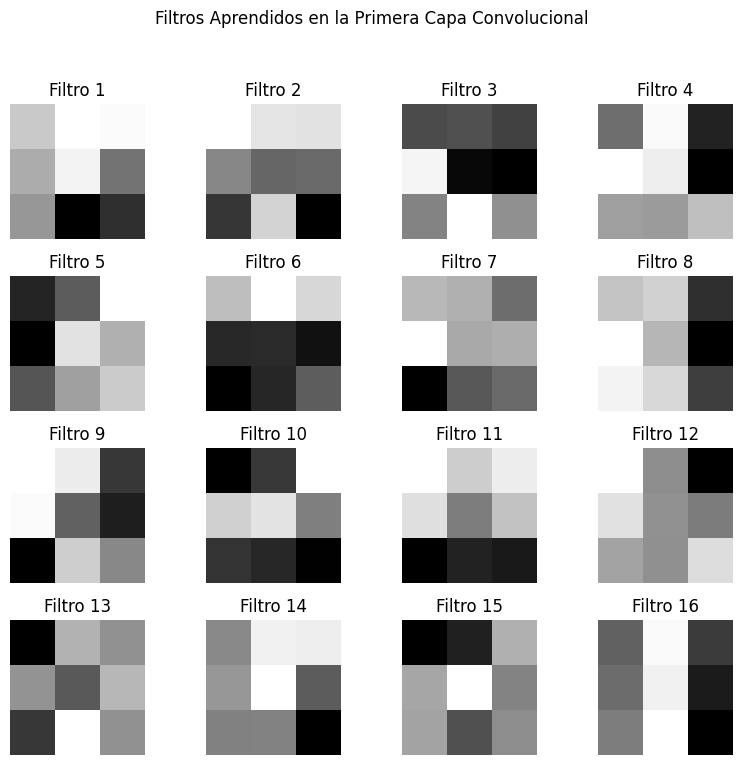


Interpretación de los filtros:

Observa los pequeños patrones que cada filtro ha aprendido a reconocer.
Algunos pueden detectar bordes verticales, otros horizontales, diagonales o esquinas.
Estos son los 'bloques de construcción' básicos que la CNN usa para comprender la imagen.


In [5]:
# Obtenemos los pesos (filtros y sesgos) de la primera capa (índice 0, que es Conv2D).
# 'get_weights()' devuelve una lista de arrays NumPy: el primer array son los filtros, el segundo son los sesgos.
filters, biases = model.layers[0].get_weights()

# Configuramos una figura para mostrar los filtros.
# Creamos una cuadrícula de 4x4 subplots (para 16 filtros).
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Filtros Aprendidos en la Primera Capa Convolucional') # Título general de la figura

# Iteramos sobre cada subplot para mostrar un filtro.
for i, ax in enumerate(axes.flat):
    # Mostramos los pesos del filtro. filters[:,:,0,i] selecciona el i-ésimo filtro.
    # El '0' en la tercera dimensión es porque MNIST tiene un solo canal de entrada.
    ax.imshow(filters[:, :, 0, i], cmap='gray') # 'gray' para ver los pesos del filtro en escala de grises.
    ax.set_title(f'Filtro {i+1}') # Título para cada filtro
    ax.axis('off') # Desactivamos los ejes para una visualización limpia.
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta el layout para que el título no se superponga
plt.show()

print("\nInterpretación de los filtros:\n")
print("Observa los pequeños patrones que cada filtro ha aprendido a reconocer.")
print("Algunos pueden detectar bordes verticales, otros horizontales, diagonales o esquinas.")
print("Estos son los 'bloques de construcción' básicos que la CNN usa para comprender la imagen.")

### 4. Visualización de Mapas de Características (Activaciones)

Los **mapas de características (o activaciones)** son las salidas de una capa convolucional después de que los filtros han procesado la entrada. Representan qué características del input han sido detectadas por cada filtro en diferentes ubicaciones.

A medida que una imagen pasa por capas más profundas, los mapas de características tienden a volverse más abstractos y complejos, detectando patrones de nivel superior a partir de las características más simples detectadas por las capas anteriores.

Para visualizar esto, crearemos un nuevo modelo que nos permita obtener las salidas de capas intermedias.

In [6]:
# Creamos un modelo intermedio para obtener las salidas de las primeras dos capas.
# 'model.layers[0].input' es la entrada a la primera capa de nuestra CNN.
# 'layer.output for layer in model.layers[:2]' selecciona las salidas de las dos primeras capas (Conv2D y MaxPooling2D).
activation_model = models.Model(inputs=model.layers[0].input, outputs=[layer.output for layer in model.layers[:2]])

# Obtenemos las activaciones para una imagen de prueba.
# Usamos la primera imagen de prueba (x_test[0]) y la reformamos a (1, 28, 28, 1) para que coincida con el batch_size.
sample_image = x_test[0][np.newaxis, ..., np.newaxis] # Añade una dimensión para el batch y para el canal si falta
sample_image = x_test[0:1] # Forma más simple y directa para obtener un batch de tamaño 1

activations = activation_model.predict(sample_image)

print(f"Activaciones obtenidas para la imagen de prueba con etiqueta: {y_test[0]}\n")

1/1 [==============================] - 1s 565ms/step
Activaciones obtenidas para la imagen de prueba con etiqueta: 7



### 4.1. Activaciones de la Primera Capa Convolucional (Conv2D)

Estos mapas de características muestran cómo cada filtro de la primera capa respondió a la imagen de entrada. Un área más brillante en el mapa indica que el filtro detectó la característica que buscaba en esa región de la imagen.

Forma de las activaciones de la primera capa: (1, 26, 26, 16)


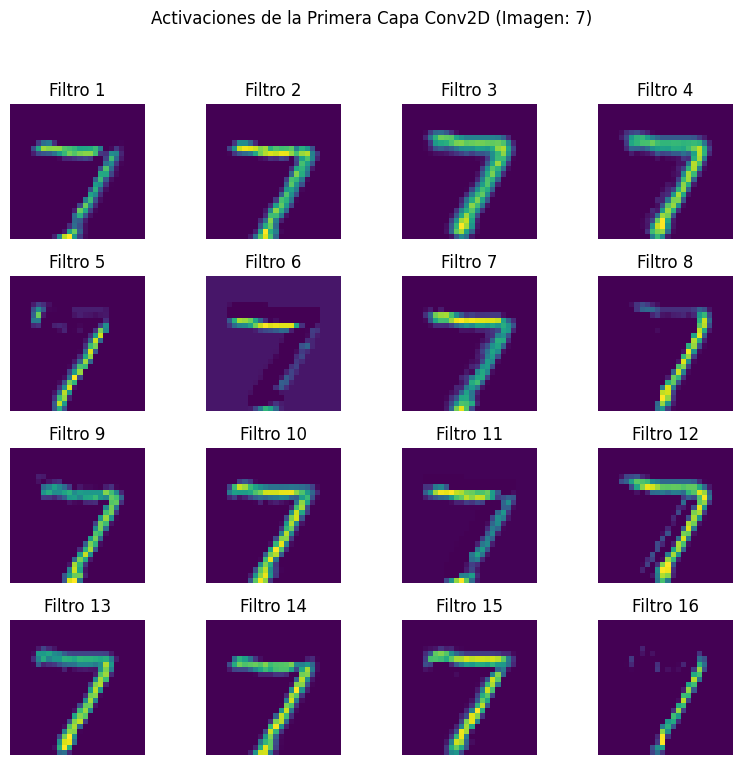


Interpretación de las activaciones Conv2D:

Cada mapa de activación muestra dónde y con qué intensidad un filtro específico 'reaccionó' a la imagen de entrada.
Observa cómo diferentes filtros resaltan diferentes características (bordes, curvas, etc.) en la imagen original.


In [7]:
first_layer_activation = activations[0]  # Activaciones de la primera capa (Conv2D)

print(f"Forma de las activaciones de la primera capa: {first_layer_activation.shape}") # (batch_size, alto, ancho, num_filtros)
num_filters_first_layer = first_layer_activation.shape[-1] # Número de filtros/canales en la salida

# Determinamos el tamaño de la cuadrícula para la visualización (ej. 4x4 para los 16 filtros).
grid_size = min(int(np.ceil(np.sqrt(num_filters_first_layer))), 4)
fig1, axes1 = plt.subplots(grid_size, grid_size, figsize=(8, 8))
fig1.suptitle(f'Activaciones de la Primera Capa Conv2D (Imagen: {y_test[0]})')

for i, ax in enumerate(axes1.flat):
    if i < num_filters_first_layer:
        # Mostramos el mapa de activación para el i-ésimo filtro de la primera imagen del lote.
        ax.imshow(first_layer_activation[0, :, :, i], cmap='viridis') # 'viridis' es un buen cmap para activaciones
        ax.set_title(f'Filtro {i+1}')
        ax.axis('off')
    else:
        ax.axis('off') # Ocultar subplots no usados
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta el layout para hacer espacio para el título
plt.show()

print("\nInterpretación de las activaciones Conv2D:\n")
print("Cada mapa de activación muestra dónde y con qué intensidad un filtro específico 'reaccionó' a la imagen de entrada.")
print("Observa cómo diferentes filtros resaltan diferentes características (bordes, curvas, etc.) en la imagen original.")

### 4.2. Activaciones de la Segunda Capa (MaxPooling2D)

Después de la capa convolucional, la capa `MaxPooling2D` reduce la resolución de los mapas de características. Esto ayuda a mantener la información más relevante y a hacer la red más robusta a pequeñas variaciones en la posición de las características.

Forma de las activaciones de la segunda capa: (1, 13, 13, 16)


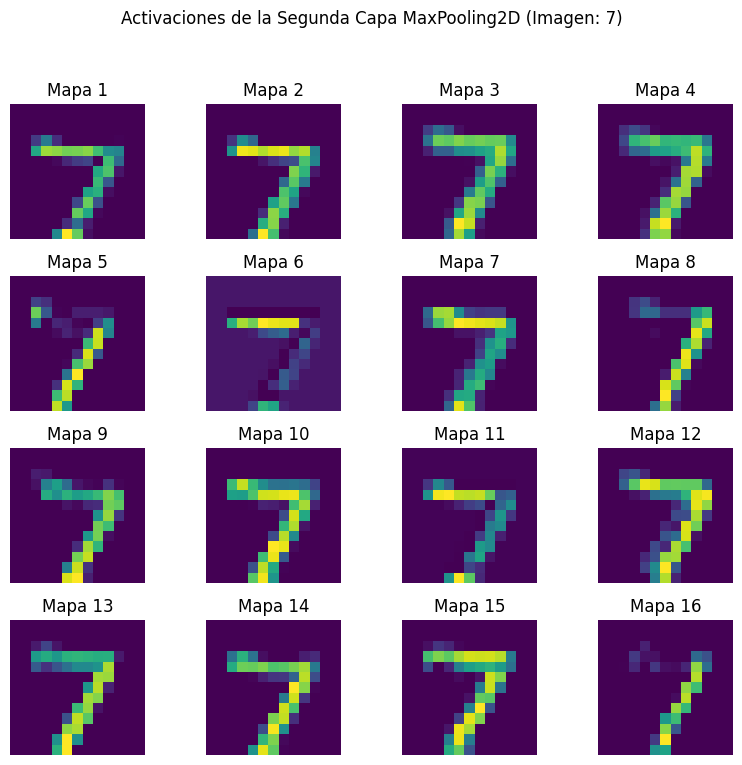


Interpretación de las activaciones MaxPooling2D:

Observa que estos mapas son de menor resolución que los anteriores.
MaxPooling reduce la dimensionalidad espacial, conservando la información más prominente detectada por los filtros.
Esto hace que la red sea más eficiente y más tolerante a pequeñas variaciones en la posición de las características.


In [8]:
second_layer_activation = activations[1] # Activaciones de la segunda capa (MaxPooling2D)

print(f"Forma de las activaciones de la segunda capa: {second_layer_activation.shape}") # (batch_size, alto_reducido, ancho_reducido, num_filtros)
num_filters_second_layer = second_layer_activation.shape[-1]

# Determinamos el tamaño de la cuadrícula para la visualización.
grid_size_pool = min(int(np.ceil(np.sqrt(num_filters_second_layer))), 4)
fig2, axes2 = plt.subplots(grid_size_pool, grid_size_pool, figsize=(8, 8))
fig2.suptitle(f'Activaciones de la Segunda Capa MaxPooling2D (Imagen: {y_test[0]})')

for i, ax in enumerate(axes2.flat):
    if i < num_filters_second_layer:
        # Mostramos el mapa de activación post-pooling.
        ax.imshow(second_layer_activation[0, :, :, i], cmap='viridis')
        ax.set_title(f'Mapa {i+1}')
        ax.axis('off')
    else:
        ax.axis('off') # Ocultar subplots no usados
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta el layout para hacer espacio para el título
plt.show()

print("\nInterpretación de las activaciones MaxPooling2D:\n")
print("Observa que estos mapas son de menor resolución que los anteriores.")
print("MaxPooling reduce la dimensionalidad espacial, conservando la información más prominente detectada por los filtros.")
print("Esto hace que la red sea más eficiente y más tolerante a pequeñas variaciones en la posición de las características.")

## Conclusión y Ejercicios Sugeridos

Has completado un ejercicio práctico de visualización en CNNs. Ahora tienes una mejor comprensión de:

-   Cómo los **filtros** en las capas convolucionales aprenden a detectar patrones básicos.
-   Cómo las **activaciones (mapas de características)** representan la presencia de esos patrones en diferentes regiones de la imagen y cómo evolucionan a través de las capas.
-   El papel de las capas de **pooling** en la reducción de dimensionalidad y la creación de representaciones más robustas.

Esta visualización es una herramienta valiosa para depurar modelos, interpretar su comportamiento y desarrollar una intuición más profunda sobre cómo funcionan las CNNs.

---
**Ejercicios Sugeridos para Experimentar:**

-   **Modificar la Arquitectura:**
    -   Añade más capas `Conv2D` y `MaxPooling2D`. ¿Cómo cambian los filtros y las activaciones en capas más profundas?
    -   Cambia el número de filtros en una capa (ej. 32 a 64). ¿Hay más variedad en los patrones aprendidos?
    -   Experimenta con diferentes tamaños de kernel (ej. 5x5 en lugar de 3x3).
-   **Entrenar por más épocas:** ¿Los filtros se vuelven más definidos o específicos con más entrenamiento?
-   **Probar con diferentes imágenes de entrada:** Selecciona diferentes dígitos del conjunto de prueba (`x_test[i]`) y observa cómo varían los mapas de características. ¿Qué patrones se activan para un '0' vs. un '1'?
-   **Visualizar capas más profundas:** Adapta el `activation_model` para extraer y visualizar las activaciones de la *segunda* capa `Conv2D` de tu modelo. ¿Son más abstractas que las de la primera capa?
-   **Cambiar la función de activación:** ¿Qué sucede si usas `sigmoid` o `tanh` en lugar de `relu`? (Ten en cuenta que `relu` es más común y eficiente para CNNs).

## Glosario de Términos

-   **Red Neuronal Convolucional (CNN):** Un tipo de red neuronal artificial especializada en procesar datos con una topología de cuadrícula, como imágenes, a través de capas convolucionales y de pooling.
-   **Filtro (Kernel):** Una pequeña matriz de pesos que se desliza sobre la imagen de entrada (o un mapa de características) para detectar patrones específicos. La red aprende los valores de estos pesos durante el entrenamiento.
-   **Activación (Mapa de Características / Feature Map):** La salida de una capa convolucional después de que un filtro ha sido aplicado y la función de activación (ej. ReLU) ha sido ejecutada. Cada mapa de características representa la presencia de una característica específica a lo largo de la imagen.
-   **Capa Convolucional (`Conv2D`):** La capa principal de una CNN. Realiza la operación de convolución utilizando filtros para extraer características locales de la entrada.
-   **Capa de Agrupación Máxima (`MaxPooling2D`):** Una capa que reduce la dimensionalidad espacial (ancho y alto) de los mapas de características, seleccionando el valor máximo dentro de cada ventana de agrupamiento. Ayuda a reducir el número de parámetros y hacer el modelo más robusto.
-   **Función de Activación (`ReLU`, `Softmax`):** Funciones no lineales que se aplican a la salida de las neuronas. `ReLU` (Rectified Linear Unit) es común en capas ocultas, mientras que `Softmax` se usa en la capa de salida para problemas de clasificación multiclase, produciendo probabilidades.
-   **Capa Densa (Fully Connected Layer):** Una capa donde cada neurona está conectada a cada neurona de la capa anterior. En las CNNs, se utilizan típicamente al final para la clasificación.
-   **Capa `Flatten`:** Convierte la entrada (usualmente de un tensor 2D o 3D, como los mapas de características) en un vector 1D, preparándola para ser conectada a una capa densa.
-   **MNIST:** Un conjunto de datos de dígitos escritos a mano ampliamente utilizado para el aprendizaje automático, especialmente para introducir redes neuronales convolucionales.
-   **Normalización:** El proceso de escalar los valores de los píxeles de una imagen (ej. de 0-255 a 0-1) para facilitar el entrenamiento del modelo y mejorar su rendimiento.
-   **Época:** Un ciclo completo de entrenamiento, donde el modelo procesa todo el conjunto de datos de entrenamiento una vez.
-   **Optimizador (`Adam`):** Un algoritmo utilizado para ajustar los pesos de la red neuronal durante el entrenamiento, con el objetivo de minimizar la función de pérdida. Adam es un optimizador adaptativo popular.
-   **Función de Pérdida (`sparse_categorical_crossentropy`):** Una métrica que el modelo intenta minimizar durante el entrenamiento. Mide la diferencia entre las predicciones del modelo y las etiquetas reales. `sparse_categorical_crossentropy` es adecuada cuando las etiquetas de clase son números enteros.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9be9d3e5-4f25-48e6-912d-b59b8644d952' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>